In [1]:
import os

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import configparser


models = np.array(['MRM61',
                  'MMAC',
                  'Heliosat1I',
                  'CEM',
                  'ESRA',
                  'METSTAT',
                  'SOLISsimple'])


models_label = np.array(['MRM v6.1',
                         'MMAC',
                         'Heliosat-1',
                         'CEM',
                         'ESRA',
                         'METSTAT',
                         'Solis simple'])

models_aodwvl = np.array([550,
                           0,
                           550,
                           0,
                           550,
                           0,
                           700])

### load dataset
# This dataset is produced with make_dataset_AOD_CSM_TCARS.py
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

fname_CAMS_AOD = os.path.join(pf,"TCARS_CSF_AOD_2015.nc")
dsAOD = xr.open_dataset(fname_CAMS_AOD)

---

## Figure 7
Annual overview of AOD from T-CARS and CSM.
CSM AODs at 700nm or broadband are scaled to 550nm.

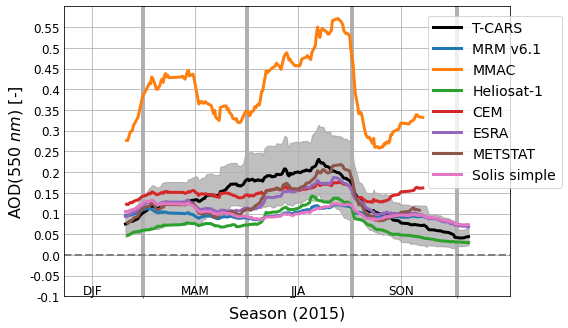

In [2]:

def calc_AE(t1,t2,l1,l2):
    """ calculate Angstrom exponent from aods (t1,t2)
        at two different wavelengths (l1,l2)
    """
    return -np.log(t1/t2)/np.log(l1/l2)
def calc_AOD(l1,t2,l2,ae):
    return t2*(l1/l2)**(-ae)

AODvgl=dsAOD.copy()

AODvgl = AODvgl.assign_coords({'dayofyear':('day',AODvgl.day.dt.dayofyear)})
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


fig,axs = plt.subplots(1,1,figsize=(8,4.8))

AOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).mean(skipna=True)
dAOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).std(skipna=True)



axs.set_title('',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD550),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD550),drop=True).rolling(day=30,center=True).std(skipna=True)
axs.fill_between(pAOD.dayofyear,
                    pAOD.AOD550-pdAOD.AOD550,
                    pAOD.AOD550+pdAOD.AOD550,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs.plot(pAOD.dayofyear.values,pAOD.AOD550,
            color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    wvl = models_aodwvl[m]
        
    AOD = AODvgl.sel(model=model).mean(dim=['station'],skipna=True)#.rolling(day=30,center=True).mean()
    pAOD = AOD.where(~np.isnan(AOD.CAOD),drop=True).interpolate_na(dim='day').rolling(day=30,center=True).mean(skipna=True)
    if wvl == 0: 
        pAOD.CAOD.values =(pAOD.CAOD * (pAOD.AOD550 / pAOD.AOD0)).values
    if wvl == 700:
        AE = calc_AE(pAOD.AOD550,pAOD.AOD700,550,700)
        pAOD.CAOD.values = calc_AOD(550.,pAOD.CAOD.values,700,AE.values)
#         pAOD.CAOD.values =(pAOD.CAOD * (pAOD.AOD550 / pAOD.AOD700)).values    

    axs.plot(pAOD.dayofyear,
                pAOD.CAOD,
                linestyle='-',linewidth=3,label=mlabel)
    
  
for i,ax in enumerate([axs]):
    ax.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))
#     ax.legend(loc=2,fontsize=14)
    ax.set_xlim([-10,380])
    ax.set_ylim([-0.05,0.6])
    # config axis labels
    ax.set_xticks(np.linspace(15,285,4))
    ax.set_yticks(np.arange(-0.1,0.6,0.05)+0.0000001)
    ax.set_xticklabels(['DJF','MAM','JJA','SON'],fontsize=14)#,fontweight='bold')
    ax.set_yticklabels(np.round(np.arange(-0.1,0.6,0.05),2),fontsize=14)
    ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
    ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
    # config for gridlines
    ax.set_xticks(np.linspace(59,334,4),minor=True)
    ax.set_yticks(np.arange(-0.1,0.3,0.05),minor = True)
    ax.grid(which='minor')
    ax.tick_params('x',which='minor',grid_linewidth=4)
    ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
    ax.set_xlabel('Season (2015)',fontsize=16)#,fontweight='bold')
    ax.grid(True)

    ax.set_ylabel(r"AOD(550 $nm$) [-]",fontsize=16)#,fontweight='bold')
    plt.legend(fontsize=14,bbox_to_anchor=(0.8, 0.35))#bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
    

plt.tight_layout()
plt.savefig('Figures/Fig07.pdf',dpi=300,bbox_inches='tight')


---

## Fig07 without AOD scaling

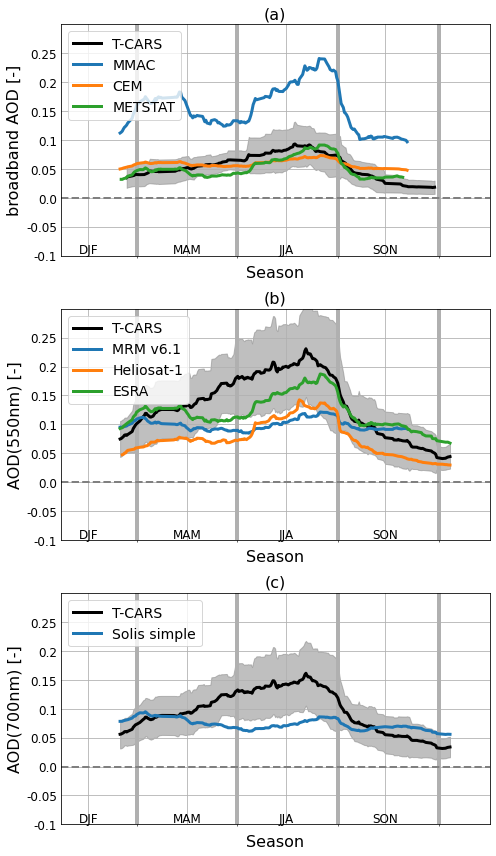

In [3]:

AODvgl=dsAOD.copy()

AODvgl = AODvgl.assign_coords({'dayofyear':('day',AODvgl.day.dt.dayofyear)})
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


fig,axs = plt.subplots(3,1,figsize=(7,12))

AOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).mean(skipna=True)
dAOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).std(skipna=True)

axs[0].set_title('(a)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD0),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD0),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[0].fill_between(pAOD.dayofyear,
                    pAOD.AOD0-pdAOD.AOD0,
                    pAOD.AOD0+pdAOD.AOD0,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[0].plot(pAOD.dayofyear.values,pAOD.AOD0,
            color='k',linewidth=3,label='T-CARS')

axs[1].set_title('(b)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD550),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD550),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[1].fill_between(pAOD.dayofyear,
                    pAOD.AOD550-pdAOD.AOD550,
                    pAOD.AOD550+pdAOD.AOD550,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[1].plot(pAOD.dayofyear.values,pAOD.AOD550,
            color='k',linewidth=3,label='T-CARS')

axs[2].set_title('(c)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD700),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD700),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[2].fill_between(pAOD.dayofyear,
                    pAOD.AOD700-pdAOD.AOD700,
                    pAOD.AOD700+pdAOD.AOD700,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[2].plot(pAOD.dayofyear.values,pAOD.AOD700,
            color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    wvl = models_aodwvl[m]
    if wvl == 0:
        i=0
    elif wvl == 550:
        i=1
    else:
        i=2
        
    AOD = AODvgl.sel(model=model).mean(dim=['station'],skipna=True)#.rolling(day=30,center=True).mean()
    pAOD = AOD.where(~np.isnan(AOD.CAOD),drop=True).rolling(day=30,center=True).mean(skipna=True)
    axs[i].plot(pAOD.dayofyear,
                pAOD.CAOD,
                linestyle='-',linewidth=3,label=mlabel)
    
  
for i,ax in enumerate(axs):
    ax.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))
    ax.legend(loc=2,fontsize=14)
    ax.set_xlim([-10,380])
    ax.set_ylim([-0.1,0.3])
    # config axis labels
    ax.set_xticks(np.linspace(15,285,4))
    ax.set_yticks(np.arange(-0.1,0.3,0.05)+0.0000001)
    ax.set_xticklabels(['DJF','MAM','JJA','SON'],fontsize=14)#,fontweight='bold')
    ax.set_yticklabels(np.round(np.arange(-0.1,0.3,0.05),2),fontsize=14)
    ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
    ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
    # config for gridlines
    ax.set_xticks(np.linspace(59,334,4),minor=True)
    ax.set_yticks(np.arange(-0.1,0.3,0.05),minor = True)
    ax.grid(which='minor')
    ax.tick_params('x',which='minor',grid_linewidth=4)
    ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
    ax.set_xlabel('Season',fontsize=16)#,fontweight='bold')
    ax.grid(True)
    if i==0:
        ax.set_ylabel("broadband AOD [-]",fontsize=16)#,fontweight='bold')
    elif i==1:
        ax.set_ylabel("AOD(550nm) [-]",fontsize=16)#,fontweight='bold')
    else:
        ax.set_ylabel("AOD(700nm) [-]",fontsize=16)#,fontweight='bold')
    

plt.tight_layout()
